<a href="https://colab.research.google.com/github/harnalashok/Clustering/blob/master/online_retail_rfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 11th April, 2021
# Ref: https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering
# My folder:
# github: harnalashok/clustering/
# 

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import os

In [2]:
# 1.1 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
path = "/content" 
os.chdir(path)
!ls -la /content


total 1040
drwxr-xr-x 1 root root    4096 Apr 13 03:48 .
drwxr-xr-x 1 root root    4096 Apr 13 03:30 ..
drwxr-xr-x 4 root root    4096 Apr  7 13:35 .config
-rw-r--r-- 1 root root 1048576 Apr 13 03:48 OnlineRetail.csv
drwxr-xr-x 1 root root    4096 Apr  7 13:36 sample_data


In [4]:
!ls -la /content

total 2064
drwxr-xr-x 1 root root    4096 Apr 13 03:48 .
drwxr-xr-x 1 root root    4096 Apr 13 03:30 ..
drwxr-xr-x 4 root root    4096 Apr  7 13:35 .config
-rw-r--r-- 1 root root 2097152 Apr 13 03:48 OnlineRetail.csv
drwxr-xr-x 1 root root    4096 Apr  7 13:36 sample_data


In [33]:
# StackOverflow
data = pd.read_csv(
                   "OnlineRetail1.csv",
                   #"onlineretail.zip",
                   encoding = "ISO_8859_1",
                   engine = 'python', # Takes time but reads full file
                                      # 'c' engine is faster but has problems
                                      # at separators. Default is 'c'
                   header = 0
                   #parse_dates=True        # InvoiceDate does not get converted to date
                   )


In [34]:
data.shape   # (541909, 8)
print()
data.dtypes  
print()
data.head()

(541909, 8)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [35]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [36]:
print("\n-----InvoiceNo------\n")
data.InvoiceNo.value_counts()     # 25900 unique
print()
print("\n-----StockCode------\n")
data.StockCode.value_counts()     # 4070  unique
print()
print("\n----CustomerID-------\n")
data.CustomerID.value_counts()    # 4372 unique
print("\n----Country-------\n")
data.Country.value_counts()    # 38 unique
print()
len(data.Country.value_counts()) # 38 unique


-----InvoiceNo------



573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
576827        1
C574558       1
543655        1
C555411       1
572056        1
Name: InvoiceNo, Length: 25900, dtype: int64



-----StockCode------



85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
46037A       1
47593b       1
72140F       1
35597B       1
47591A       1
Name: StockCode, Length: 4070, dtype: int64



----CustomerID-------



17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
13391.0       1
16579.0       1
13366.0       1
17763.0       1
17846.0       1
Name: CustomerID, Length: 4372, dtype: int64


----Country-------



United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

38

In [37]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [38]:
data = data[~data["CustomerID"].isnull()]
data.shape  # (406829, 8)

(406829, 8)

In [39]:
#checking for duplicates
data = data[~data.duplicated()]
data.shape   # (401604, 8)  ; data.drop_duplicates(keep='first', inplace=True)

(401604, 8)

In [40]:
data.sort_values(by = "InvoiceDate", ascending = False).head()
data.sort_values(by = "InvoiceDate",ascending = False).tail()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
394691,570876,23083,SET 6 PAPER TABLE LANTERN STARS,2,2011-12-10 17:19:00,3.75,16085.0,United Kingdom
394690,570876,22469,HEART OF WICKER SMALL,3,2011-12-10 17:19:00,1.65,16085.0,United Kingdom
394694,570876,23509,MINI PLAYING CARDS FUN FAIR,4,2011-12-10 17:19:00,0.42,16085.0,United Kingdom
394695,570876,23048,SET OF 10 LANTERNS FAIRY LIGHT STAR,2,2011-12-10 17:19:00,4.15,16085.0,United Kingdom
394696,570876,23503,PLAYING CARDS KEEP CALM & CARRY ON,4,2011-12-10 17:19:00,1.25,16085.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-01-12 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-01-12 08:26:00,4.25,17850.0,United Kingdom
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom


In [51]:
# Last purchase date of each customer
# Groupby customerID
# Sort by date
# Get first date


In [41]:
data['rev'] = data['UnitPrice'] * data['Quantity']

In [42]:
df = data.copy()

In [43]:
grd = df.groupby("CustomerID")

In [44]:
df_recency = pd.DataFrame(columns = df.columns)
df_recency.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,rev


In [45]:
for i, d in grd:
  d = d.reset_index().sort_values(by = ['InvoiceDate'], ascending = False)
  df_recency = pd.concat([df_recency, d.head(1)])

In [46]:
df_recency.shape     # (4372,10)
print()
df_recency.head()
print()
df_recency[['CustomerID', 'InvoiceDate']].head()
print()
df_recency['InvoiceDate'].min()
print()
df_recency['recency']= (df_recency['InvoiceDate'].max() - df_recency['InvoiceDate'])/ pd.Timedelta("1 days")
print()
df_recency = df_recency[['CustomerID', 'recency']]

(4372, 10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,rev,index
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.6,61624.0
145,573511,23508,MINI PLAYING CARDS DOLLY GIRL,20,2011-10-31 12:25:00,0.42,12347.0,Iceland,8.4,428978.0
30,568172,POST,POSTAGE,1,2011-09-25 13:13:00,40.00,12348.0,Finland,40.0,359060.0
0,577609,23112,PARISIENNE CURIO CABINET,2,2011-11-21 09:51:00,7.50,12349.0,Italy,15.0,485502.0
0,543037,21908,CHOCOLATE THIS WAY METAL SIGN,12,2011-02-02 16:01:00,2.10,12350.0,Norway,25.2,80323.0


,CustomerID,InvoiceDate
1,12346.0,2011-01-18 10:17:00
145,12347.0,2011-10-31 12:25:00
30,12348.0,2011-09-25 13:13:00
0,12349.0,2011-11-21 09:51:00
0,12350.0,2011-02-02 16:01:00


Timestamp('2010-01-12 09:53:00')

In [47]:
df_recency.head()
df_recency.recency.min()

,CustomerID,recency
1,12346.0,326.293056
145,12347.0,40.204167
30,12348.0,76.170833
0,12349.0,19.311111
0,12350.0,311.054167


0.0

In [48]:
grpd = df.groupby(['CustomerID'])

In [49]:
df_freq = grpd['InvoiceNo'].nunique().reset_index()
df_freq.columns = ['CustomerID', 'frequency']
df_freq.head()


,CustomerID,frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [50]:
grpd = df.groupby('CustomerID')

In [51]:
df_rev = grpd['rev'].sum().reset_index()
df_rev.columns = ['CustomerID', 'revenue']
df_rev.head()

,CustomerID,revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [52]:
rfm = df_rev.merge(df_recency)
rfm = rfm.merge(df_freq)
rfm.shape
rfm.head()


(4372, 4)

,CustomerID,revenue,recency,frequency
0,12346.0,0.00,326.293056,2
1,12347.0,4310.00,40.204167,7
2,12348.0,1797.24,76.170833,4
3,12349.0,1757.55,19.311111,1
4,12350.0,334.40,311.054167,1


In [53]:
rfm.shape    # (4372, 4)

(4372, 4)

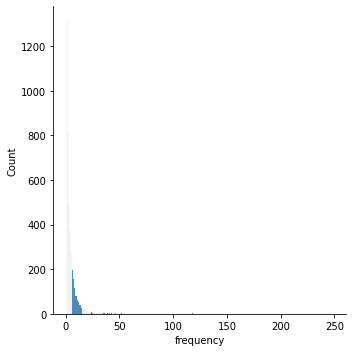

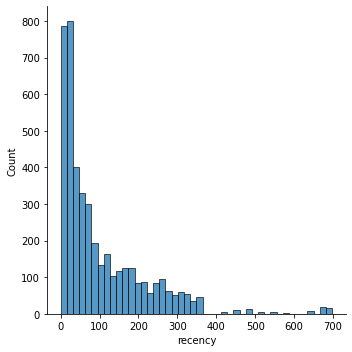

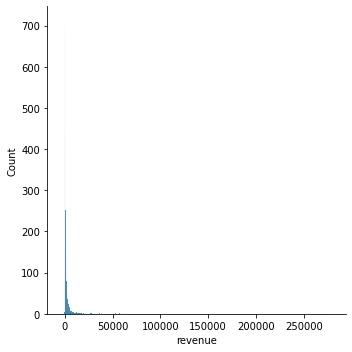

In [82]:
sns.displot(rfm.frequency)
sns.displot(rfm.recency)
sns.displot(rfm.revenue)

IQR

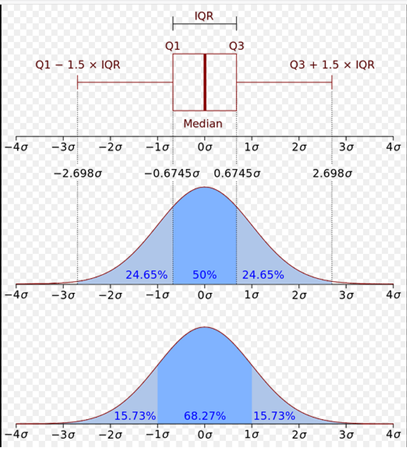



Quantile vs Quartile vs Percentile<br>
Refer [here](https://stats.stackexchange.com/a/156787)

> 0 quartile = 0 quantile = 0 percentile

> 1 quartile = 0.25 quantile = 25 percentile

> 2 quartile = .5 quantile = 50 percentile (median)

> 3 quartile = .75 quantile = 75 percentile

> 4 quartile = 1 quantile = 100 percentile


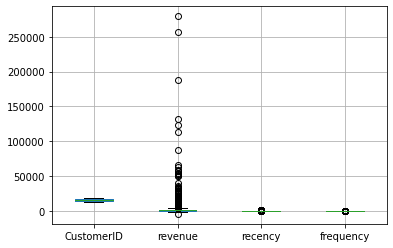

In [55]:
_=rfm.boxplot()

In [61]:
cols = ["revenue", "frequency", "recency"]
print("\n\n----0.99 quantile-----\n")
rfm[cols].quantile(0.99)
print("\n\n----0.75 quantile-----\n")
rfm[cols].quantile(0.75)
print("\n\n----0.25 quantile-----\n")
rfm[cols].quantile(0.25)
print("\n\n----iqr-----\n")
iqr = rfm[cols].quantile(0.75) - rfm[cols].quantile(0.25)
print()
iqr  # rev: 1316, recency: 132,frequency: 4.0 



----0.99 quantile-----



revenue      17226.29490
frequency       36.00000
recency        546.22316
Name: 0.99, dtype: float64



----0.75 quantile-----



revenue      1608.335000
frequency       5.000000
recency       152.244965
Name: 0.75, dtype: float64



----0.25 quantile-----



revenue      291.795000
frequency      1.000000
recency       20.183681
Name: 0.25, dtype: float64



----iqr-----




revenue      1316.540000
frequency       4.000000
recency       132.061285
dtype: float64

In [62]:
from scipy import stats
iqr_rev = stats.iqr(rfm.revenue, interpolation = 'midpoint')
iqr_recency = stats.iqr(rfm.recency, interpolation = 'midpoint')
iqr_freq = stats.iqr(rfm.frequency, interpolation = 'midpoint')
print()
print("iqr_rev:", iqr_rev)
print("iqr_recency: ", iqr_recency)
print("iqr_freq: ", iqr_freq)


iqr_rev: 1317.23
iqr_recency:  132.06631944444445
iqr_freq:  4.0


#### Using IQR to calculate outliers

In [85]:
q1 = rfm['frequency'].quantile(0.25)
q3 = rfm['frequency'].quantile(0.75)
q1
print()
q3
print()
iqr = q3 - q1
iqr
upper_lt = q3 + iqr * 1.5
lower_lt = q1 + iqr * 1.5
rfm.loc[(rfm['frequency'] >lower_lt) & (rfm['frequency'] < upper_lt), : ].head()

1.0

5.0

4.0

,CustomerID,revenue,recency,frequency
49,12408.0,2842.57,128.007639,9
61,12423.0,1849.11,89.297917,9
97,12464.0,1212.05,11.156944,8
102,12473.0,2837.73,54.244444,9
106,12477.0,13117.01,23.311111,9


In [94]:
def rem_outliers(feature, data):
  q1 = data[feature].quantile(0.25)
  q3 = data[feature].quantile(0.75)
  iqr = q3-q1
  upper_lt = q3 + iqr * 1.5
  lower_lt = q1 - iqr * 1.5
  return data.loc[(data[feature] >lower_lt) & (data[feature] < upper_lt), : ] 




(3913, 4)

,CustomerID,revenue,recency,frequency
0,12346.0,0.00,326.293056,2
1,12347.0,4310.00,40.204167,7
2,12348.0,1797.24,76.170833,4
3,12349.0,1757.55,19.311111,1
4,12350.0,334.40,311.054167,1


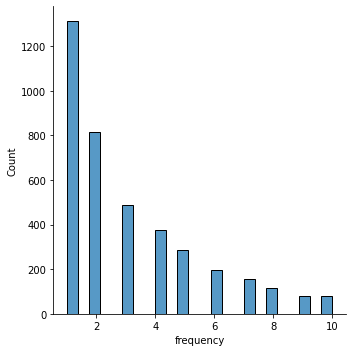

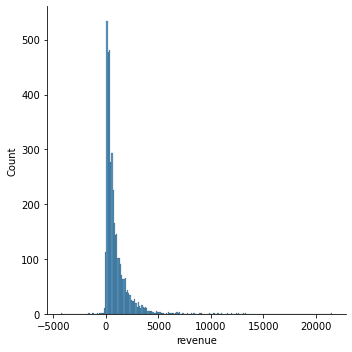

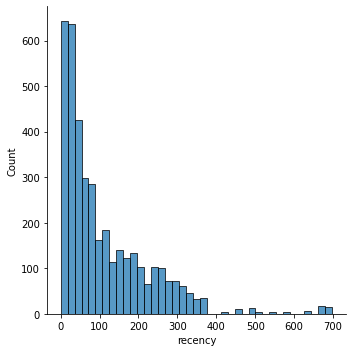

In [95]:
rfm_freq = rem_outliers('frequency', rfm) 
rfm_freq.shape    # (3913,4)
rfm_freq.head()
sns.displot(rfm_freq.frequency);
sns.displot(rfm_freq.revenue);
sns.displot(rfm_freq.recency);

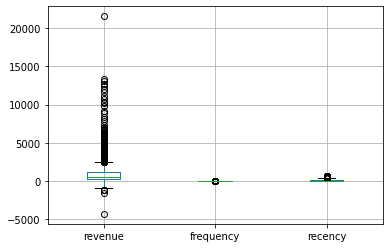

In [71]:
rfm_freq[cols].boxplot()

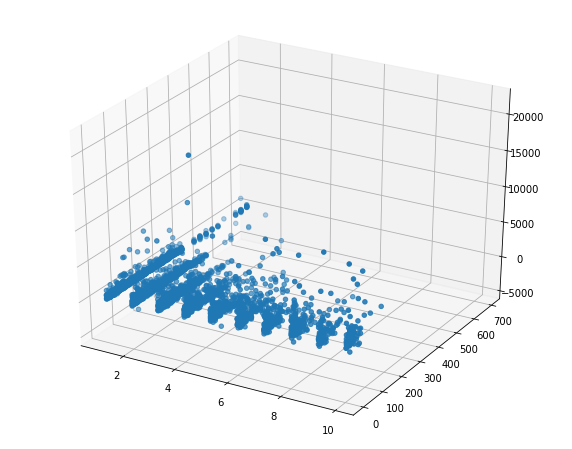

In [93]:
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(
             rfm_freq.frequency.values,
             rfm_freq.recency.values,
             rfm_freq.revenue.values,
             cmap='Greens');

(4244, 4)

,CustomerID,revenue,recency,frequency
0,12346.0,0.00,326.293056,2
1,12347.0,4310.00,40.204167,7
2,12348.0,1797.24,76.170833,4
3,12349.0,1757.55,19.311111,1
4,12350.0,334.40,311.054167,1


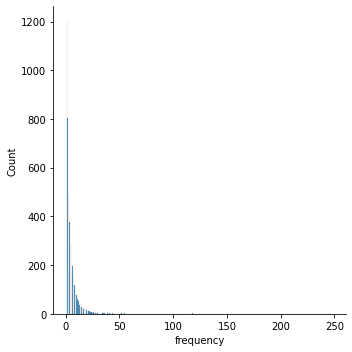

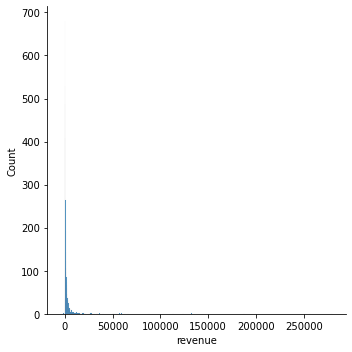

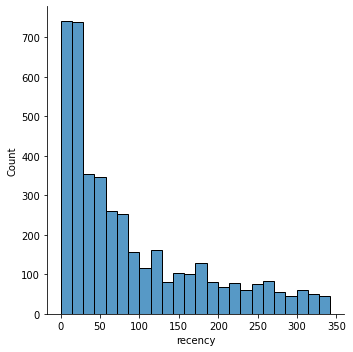

In [96]:
rfm_recency = rem_outliers('recency', rfm) 
rfm_recency.shape    # (4244, 4)
rfm_recency.head()
sns.displot(rfm_recency.frequency);
sns.displot(rfm_recency.revenue);
sns.displot(rfm_recency.recency);

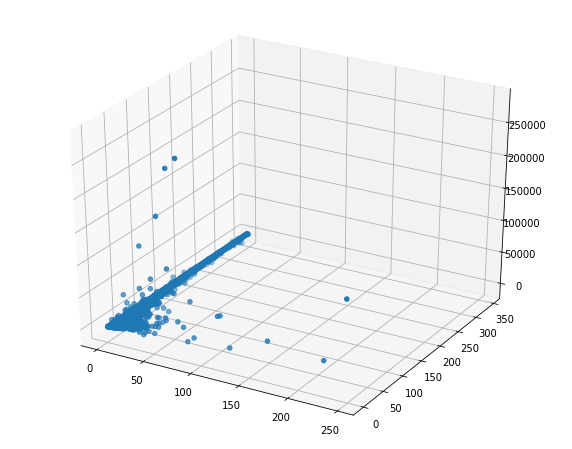

In [97]:
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(
             rfm_recency.frequency.values,
             rfm_recency.recency.values,
             rfm_recency.revenue.values,
             cmap='Greens');

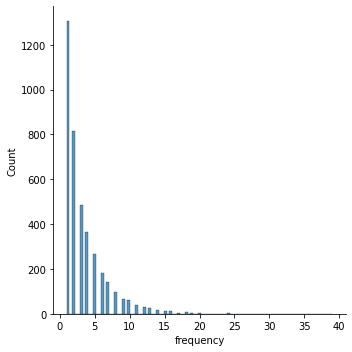

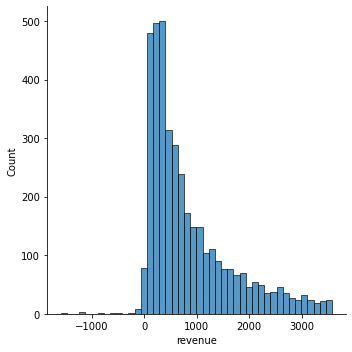

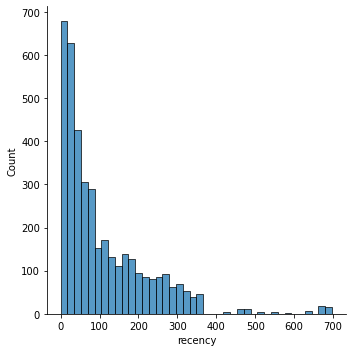

In [98]:
rfm_revenue = rem_outliers('revenue', rfm) 
rfm_revenue.shape    # (4244, 4)
rfm_revenue.head()
sns.displot(rfm_revenue.frequency);
sns.displot(rfm_revenue.revenue);
sns.displot(rfm_revenue.recency);

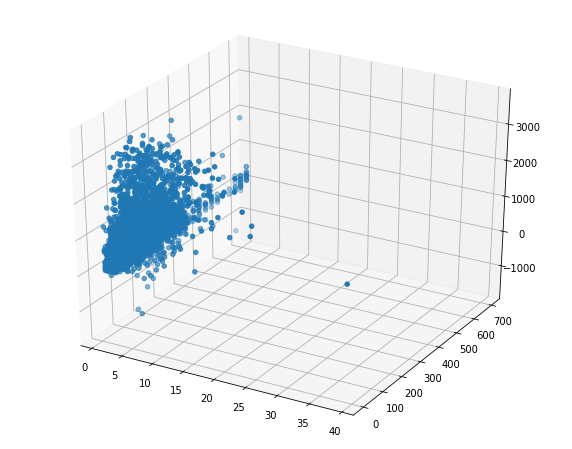

In [99]:
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(
             rfm_revenue.frequency.values,
             rfm_revenue.recency.values,
             rfm_revenue.revenue.values,
             cmap='Greens');

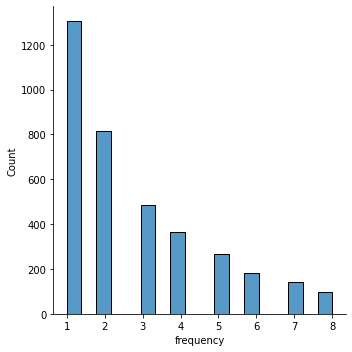

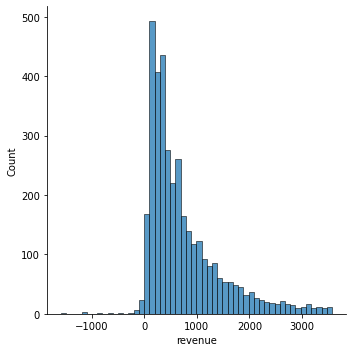

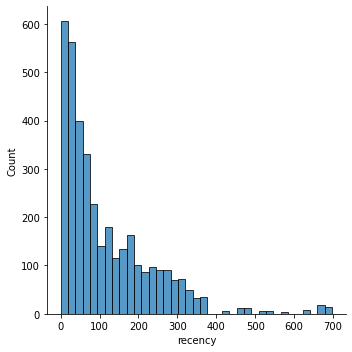

In [100]:
rfm_freq2 = rem_outliers('frequency', rfm_revenue) 
rfm_freq2.shape    # (4244, 4)
rfm_freq2.head()
sns.displot(rfm_freq2.frequency);
sns.displot(rfm_freq2.revenue);
sns.displot(rfm_freq2.recency);

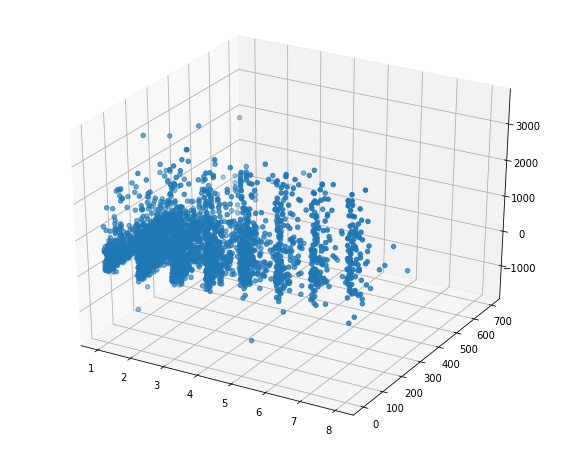

In [101]:
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(
             rfm_freq2.frequency.values,
             rfm_freq2.recency.values,
             rfm_freq2.revenue.values,
             cmap='Greens');

In [103]:
#Another way
# Removing (statistical) outliers for Amount
lower_rev = rfm.revenue.quantile(0.05)
upper_rev = rfm.revenue.quantile(0.95)
rfm_aw = rfm[(rfm.revenue >= lower_rev) & (rfm.revenue <= upper_rev)]

# Removing (statistical) outliers for Recency
lower_rec = rfm.recency.quantile(0.05)
upper_rec = rfm.recency.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.recency >= lower_rec) & (rfm_aw.recency <= upper_rec)]

# Removing (statistical) outliers for Frequency
lower_freq = rfm_aw.frequency.quantile(0.05)
upper_freq = rfm_aw.frequency.quantile(0.95)
rfm_aw = rfm_aw[(rfm_aw.frequency >= lower_freq) & (rfm_aw.frequency <= upper_freq)]
rfm_aw.shape  # (3442, 4)
rfm_aw.head()

(3442, 4)

,CustomerID,revenue,recency,frequency
1,12347.0,4310.00,40.204167,7
2,12348.0,1797.24,76.170833,4
3,12349.0,1757.55,19.311111,1
4,12350.0,334.40,311.054167,1
5,12352.0,1545.41,73.097917,11


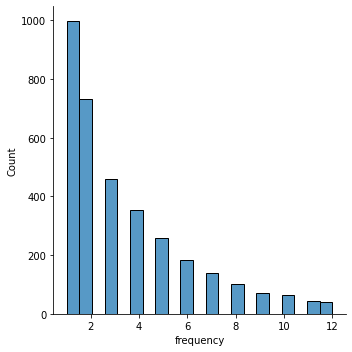

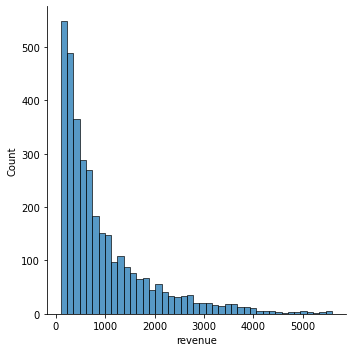

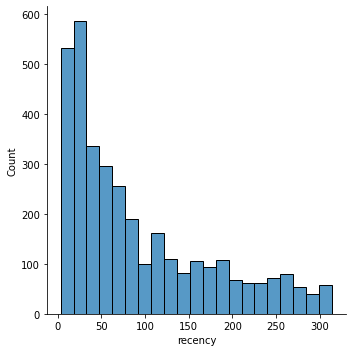

In [104]:
sns.displot(rfm_aw.frequency);
sns.displot(rfm_aw.revenue);
sns.displot(rfm_aw.recency);

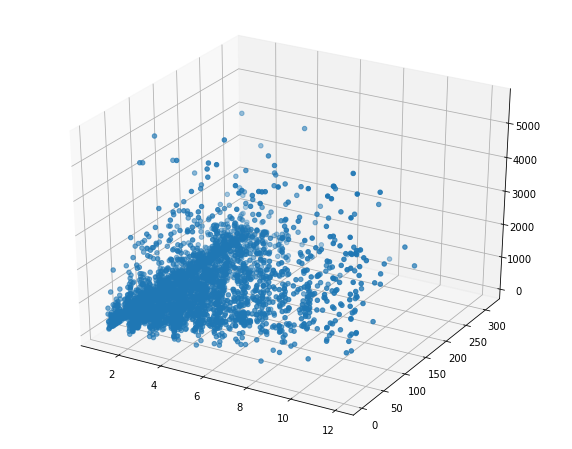

In [105]:
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(
             rfm_aw.frequency.values,
             rfm_aw.recency.values,
             rfm_aw.revenue.values,
             cmap='Greens');

In [107]:
# Rescaling the attributes

rfm_df = rfm_aw[['revenue', 'frequency', 'recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3442, 3)

In [108]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,3.499515,1.374147,-0.625287
1,0.867368,0.232415,-0.187529
2,0.825792,-0.909316,-0.879580
3,-0.664975,-0.909316,2.671283
4,0.603573,2.896455,-0.224930


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

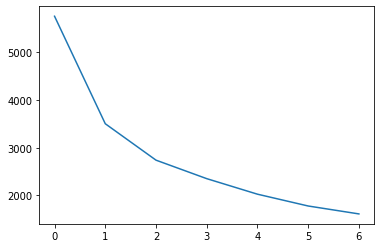

In [109]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [110]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters=2, the silhouette score is 0.44713667409628666


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters=3, the silhouette score is 0.4369924706771643


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters=4, the silhouette score is 0.39586363462275986


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters=5, the silhouette score is 0.3755776348271466


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters=6, the silhouette score is 0.3537627882273807


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters=7, the silhouette score is 0.3576028247263084


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters=8, the silhouette score is 0.3299536678792299


In [111]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [113]:
# assign the label
rfm_aw['Cluster_Id'] = kmeans.labels_
rfm_aw.head()

,CustomerID,revenue,recency,frequency,Cluster_Id
1,12347.0,4310.00,40.204167,7,0
2,12348.0,1797.24,76.170833,4,2
3,12349.0,1757.55,19.311111,1,2
4,12350.0,334.40,311.054167,1,1
5,12352.0,1545.41,73.097917,11,0


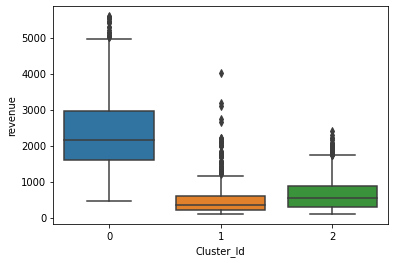

In [124]:
sns.boxplot(x='Cluster_Id', y='revenue', data=rfm_aw);

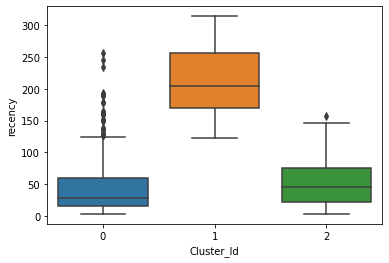

In [116]:
sns.boxplot(x='Cluster_Id', y='recency', data=rfm_aw);

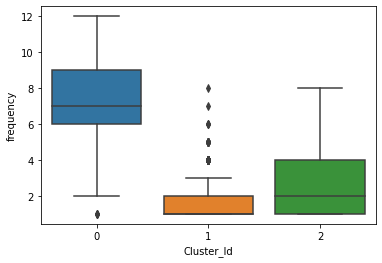

In [117]:
sns.boxplot(x='Cluster_Id', y='frequency', data=rfm_aw);

In [119]:
rfm_aw.shape

(3442, 5)

In [ ]:

# 4.0 Import GaussianMixture class
from sklearn.mixture import GaussianMixture

# 4.1 Perform clsutering
gm = GaussianMixture(
                     n_components = 3,
                     n_init = 10,
                     max_iter = 100)

# 4.2 Train the algorithm
cols = ['frequency', 'recency', 'revenue']
gm.fit(rfm_aw[['frequency', 'recency', 'revenue']])

# 4.3 Where are the clsuter centers
gm.means_

# 4.4 Did algorithm converge?
gm.converged_

# 4.5 How many iterations did it perform?
gm.n_iter_

# 4.6 Clusters labels
cid = gm.predict(rfm_aw[['frequency', 'recency', 'revenue']])


In [122]:
rfm_aw['cid'] = cid
rfm_aw.head()

,CustomerID,revenue,recency,frequency,Cluster_Id,cid
1,12347.0,4310.00,40.204167,7,0,2
2,12348.0,1797.24,76.170833,4,2,0
3,12349.0,1757.55,19.311111,1,2,2
4,12350.0,334.40,311.054167,1,1,1
5,12352.0,1545.41,73.097917,11,0,2


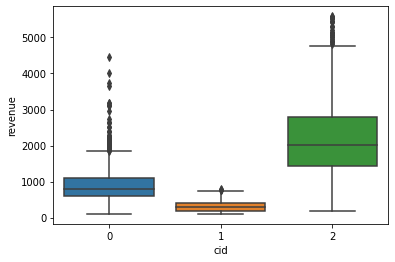

In [123]:
sns.boxplot(x='cid', y='revenue', data=rfm_aw);

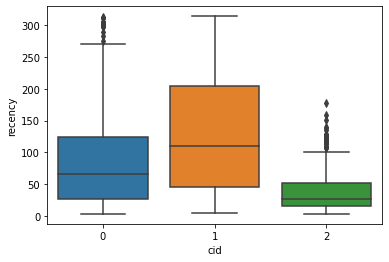

In [125]:
sns.boxplot(x='cid', y='recency', data=rfm_aw);

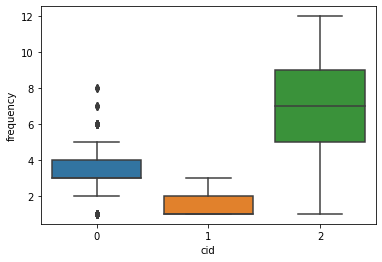

In [126]:
sns.boxplot(x='cid', y='frequency', data=rfm_aw);

In [134]:
bic = []
aic = []
cols = ['frequency', 'recency', 'revenue']
for i in range(8):
    print()
    print("No of clusters: ", i)
    print()
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 100)
    gm.fit(rfm_aw[cols])
    bic.append(gm.bic(rfm_aw[cols]))
    aic.append(gm.aic(rfm_aw[cols]))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [ ]:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
bic = []
aic = []
n_components_range = range(1, 8)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gm.fit(rfm_aw[cols])
        bic.append(gm.bic(rfm_aw[cols]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [132]:
aic
print()
bic

[110771.87514025526,
 105828.60518971454,
 104721.37579704395,
 103886.38949057681,
 103233.3837636477,
 92106.82704830833,
 91897.0148479156,
 78728.64007323244]

[110827.1694120462,
 105945.3375412732,
 104899.54622837032,
 104125.9980016709,
 103534.4303545095,
 92469.31171893785,
 92320.93759831284,
 79214.00090339739]

In [133]:
rfm_aw.to_csv("rfm_aw.csv",index=False)

How the plots look like:

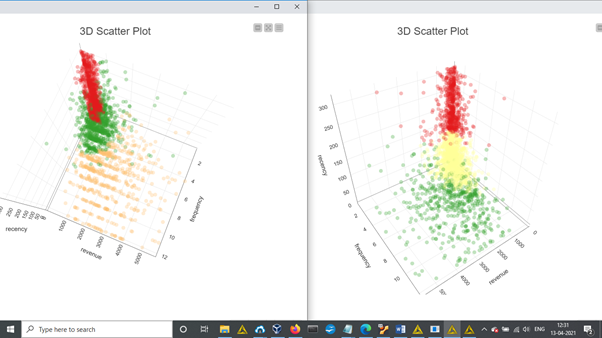



Another view

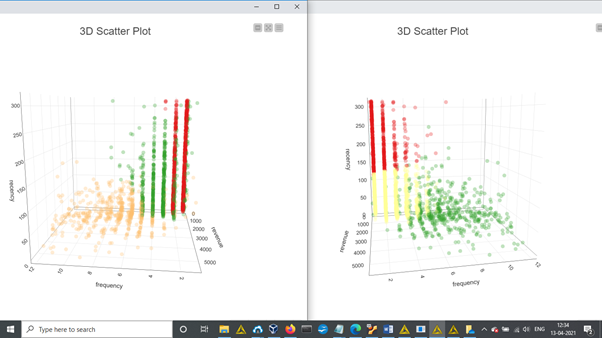

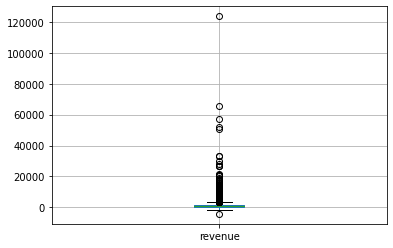

In [233]:
rfm[rfm.frequency < 36][['revenue']].boxplot()

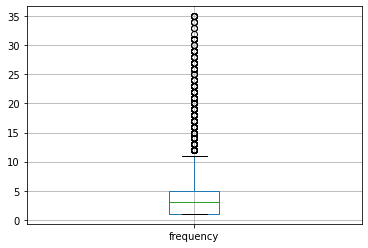

In [234]:
rfm[rfm.frequency < 36][['frequency']].boxplot()

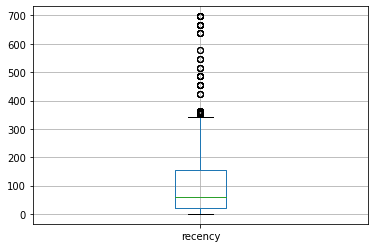

In [235]:
rfm[rfm.frequency < 36][['recency']].boxplot()

In [70]:
from scipy import stats
IQR = stats.iqr(rfm.revenue, interpolation = 'midpoint')
IQR    # 1317.23

1317.23

In [ ]:
rfm[rfm.frequency < 36][['recency']].boxplot()